# Introduction to pyjeo

**Material provided by Dr. Pieter Kempeneers (European Commission, Joint Research Centre)**

_Note: this is the same document as [https:spatial-ecology.net/docs/build/html/PKTOOLS/pyjeo_introduction.html](https:spatial-ecology.net/docs/build/html/PKTOOLS/pyjeo_introduction.html)._

[pyjeo](https://pyjeo.readthedocs.io) is the follow up of [PKTOOLS](http://pktools.nongnu.org/html/index.html), a suite of utilities written in C++ for image processing with a focus on remote sensing applications. It is distributed under a General Public License (GPLv3) as a Python package.

In a nutshell, the main differences between pyjeo and pktools from a user's perspective are:

- pyjeo is a Python package should be run in a **Python environment**, whereas pktools applications are run from the command line (e.g., in a bash shell)
- pyjeo runs with images entirely **in memory**, whereas pktools runs most applications line per line. This makes pyjeo considerably faster, but with a larger memory footprint. However, there are some methods implemented in pyjeo to reduce the memory footprint by tiling the image


Run the following script to perform the installation of pyjeo

    sudo apt update
    sudo apt upgrade -y  
    cd ~/Downloads
    wget https://raw.githubusercontent.com/selvaje/SE_data/main/exercise/install_pyjeo.sh
    sudo install_pyjeo.sh



Import Python modules

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import pyjeo as pj

Call the inline help function for [pj.geometry.warp](https://pyjeo.readthedocs.io/en/latest/3_reference.html#geometry.warp)

In [2]:
help(pj.geometry.warp)

Help on function warp in module pyjeo.modules.geometry:

warp(jim_object, t_srs=None, bbox: list = None, ulx: float = None, uly: float = None, ulz: float = None, lrx: float = None, lry: float = None, lrz: float = None, dx: float = None, dy: float = None, **kwargs)
    Warp a raster dataset to a target spatial reference system.
    
    :param jim_object: a Jim object
    :param t_srs: Target spatial reference system
    :param bbox: bounding box (instead of ulx, uly, lrx, lry)
    :param ulx: Upper left x value of bounding box
    :param uly: Upper left y value of bounding box
    :param lrx: Lower right x value of bounding box
    :param lry: Lower right y value of bounding box
    :param dx: spatial resolution in x)
    :param dy: spatial resolution in y)
    :param kwargs: See table below
    :return: warped image as Jim instance
    
    
    +----------+---------------------------------------------------------------------------------------------------+
    | key      | value      

## Jim: a geospatial raster dataset object

Open an image and show its properties

In [3]:
jim = pj.Jim('geodata/vegetation/ETmean08-11.tif')
jim

In [4]:
jim.properties.nrOfCol()

720

A Jim object is a geospatial dataset within a coordinate reference system

In [5]:
jim.properties.getProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

From [gdal](https://gdal.org/tutorials/geotransforms_tut.html#introduction-to-geotransforms): "A geotransform is an affine transformation from the image coordinate space (row, column), also known as (pixel, line) to the georeferenced coordinate space (projected or geographic coordinates)"

Geotransform is an array with 6 items:

[0] top left x

[1] w-e pixel resolution

[2] rotation, 0 if image is “north up”

[3] top left y

[4] rotation, 0 if image is “north up”

[5] n-s pixel resolution

In [6]:
jim.properties.getGeoTransform()

[29.0, 0.00833333334, 0.0, 4.000000004, 0.0, -0.00833333334]

We have a single band and single plane raster object

In [7]:
jim.properties.nrOfBand()

1

In [8]:
jim.properties.nrOfPlane()

1

Open a second GeoTIFF image of the same dimension

In [9]:
gpp = pj.Jim('geodata/vegetation/GPPmean08-11.tif')
gpp

In [10]:
gpp.properties.nrOfBand()

1

In [11]:
gpp.properties.nrOfPlane()

1

Stack this image to the existing bands of jim, creating a multi-band jim object

In [12]:
jim.geometry.stackBand(gpp)

In [13]:
jim.properties.nrOfBand()

2

## Exercise 1: stackBand function vs. method

Create a new jim object `jim_stacked` using the [stackBand](https://pyjeo.readthedocs.io/en/latest/3_reference.html#geometry.stackBand) function instead of the [stackBand](https://pyjeo.readthedocs.io/en/latest/3_reference.html#geometry._Geometry.stackBand) method. It should contain two bands, one for `ETmean08-11.tif` and one for `GPPmean08-11.tif`.

In [14]:
jimlist = pj.JimList([jim,gpp])
jim_stacked = pj.geometry.stackBand(jimlist)

## Labeled dimensions

Let's label the dimensions

In [15]:
bandnames = ['ET', 'GPP']
planenames = [datetime.strptime('2019-08-11','%Y-%m-%d')]
jim.properties.setDimension({'band' : bandnames, 'plane' : planenames})

In [16]:
jim.properties.getDimension('band')

['ET', 'GPP']

In [17]:
jim.properties.getDimension('plane')

[datetime.datetime(2019, 8, 11, 0, 0)]

## Exercise 2: cropBand using numbered and labeled index

Crop second band as a new image (index starts from 0)

In [18]:
jim1 = pj.geometry.cropBand(jim, 1)

Create a new jim object `gpp` that contains the second band using the [cropBand]() function and the labeled index ('GPP')

In [19]:
gpp = pj.geometry.cropBand(jim, 'GPP')

Check if results are identical

In [20]:
jim1.properties.isEqual(gpp)

True

In [21]:
jim1.properties.getDimension()

{'plane': [datetime.datetime(2019, 8, 11, 0, 0)], 'band': ['GPP']}

## Working with multi-plane Jim objects

First convert the bands to planes using [band2plane](https://pyjeo.readthedocs.io/en/latest/3_reference.html#geometry._Geometry.band2plane)

In [22]:
jim.geometry.band2plane()

The labels of band are copied to plane

In [23]:
jim.properties.getDimension()

{'band': [], 'plane': ['ET', 'GPP']}

## Calculate composites via reducePlane

Reduce the planes by calculating the mean of all planes

In [24]:
jim_mean = pj.geometry.reducePlane(jim, 'mean')

/home/user/venv/lib/python3.10/site-packages/numpy/core/_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Where is the RuntimeWarning coming from?

In [25]:
jim.stats.getStats()

{'min': -3.3999999521443642e+38, 'max': 9.73831558227539, 'mean': -inf}

In [26]:
jim[jim < 0] = 0
jim.stats.getStats()

{'min': 0.0, 'max': 9.73831558227539, 'mean': 2.695272207260132}

In [27]:
jim_mean = pj.geometry.reducePlane(jim, 'mean')

### Calculate custom composites via callback function in reducePlane

In [28]:
def getMax(reduced, plane):
    return pj.pixops.supremum(reduced, plane)
jim_max = pj.geometry.reducePlane(jim, getMax)

Crop the plane `ET` from `jim` using the method [cropPlane](https://pyjeo.readthedocs.io/en/latest/3_reference.html#geometry._Geometry.cropPlane). Check the resulting `jim` is a single plane and single band Jim object

In [29]:
jim.geometry.cropPlane('ET')
print(jim.properties.nrOfPlane())
print(jim.properties.nrOfBand())

1
1


In [30]:
jim.geometry.plane2band()
bandnames = ['ET']
planenames = [datetime.strptime('2019-08-11','%Y-%m-%d')]
jim.properties.setDimension({'band' : bandnames, 'plane' : planenames})

## Bridging to third party libraries: Numpy

In [31]:
jim.np()

array([[3.903193  , 4.1704483 , 4.4033966 , ..., 0.        , 0.80441576,
        0.7995924 ],
       [3.9995923 , 3.738315  , 4.336617  , ..., 0.7857337 , 0.8027174 ,
        0.8042799 ],
       [3.8954484 , 4.001087  , 4.018682  , ..., 0.7930027 , 0.8086957 ,
        0.82391304],
       ...,
       [3.9974184 , 3.9528532 , 2.32303   , ..., 3.359375  , 3.2286685 ,
        3.0525136 ],
       [3.860394  , 2.383356  , 2.3200407 , ..., 3.5756793 , 3.2909646 ,
        3.327106  ],
       [3.8717391 , 3.282405  , 3.448913  , ..., 3.6081522 , 3.559375  ,
        3.5692935 ]], dtype=float32)

Check the type of jim.np()

In [32]:
type(jim.np())

numpy.ndarray

Use [sum](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.sum.html#numpy-ndarray-sum) function of Numpy to assert there are no pixels where `jim_max < jim_mean`

In [33]:
(jim_max < jim_mean).np().sum()

0

### Get items

With pyjeo we create the masks in memory in a "pythonic" way using [get items](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#get-jim-items) without the need to write temporary files.

Get sub-dataset based on pixel coordinates (first 3 rows and columns, starting from 0)

In [34]:
jim[0:3,0:3]

Last 3 rows and columns, show geographic bounding box [ulx, uly, lrx, lry]

In [35]:
jim[-3:,-3:].properties.getBBox()

[34.97500000478, -0.9749999999800003, 35.0000000048, -1.0000000000000002]

In [36]:
jim[0:3,0:3].np()

array([[3.903193 , 4.1704483, 4.4033966],
       [3.9995923, 3.738315 , 4.336617 ],
       [3.8954484, 4.001087 , 4.018682 ]], dtype=float32)

### Set items

In pyjeo, we can apply the mask in a "pythonic" way using [set items](https://jeodpp.jrc.ec.europa.eu/services/processing/pyjeohelp/3_reference.html#set-jim-items)

In [37]:
jim[0:3,0:3] = 0
jim[0:5,0:5].np()

array([[0.       , 0.       , 0.       , 4.5625   , 4.419769 ],
       [0.       , 0.       , 0.       , 3.9793477, 4.114334 ],
       [0.       , 0.       , 0.       , 4.02894  , 3.8538043],
       [4.3265624, 4.3577447, 4.1216035, 3.8828125, 3.6519022],
       [3.9654212, 4.1422553, 4.012704 , 4.0539403, 3.761413 ]],
      dtype=float32)

**Display image using matplotlib**

We can show an image with matplotlib by providing a Numpy representation of the dataset

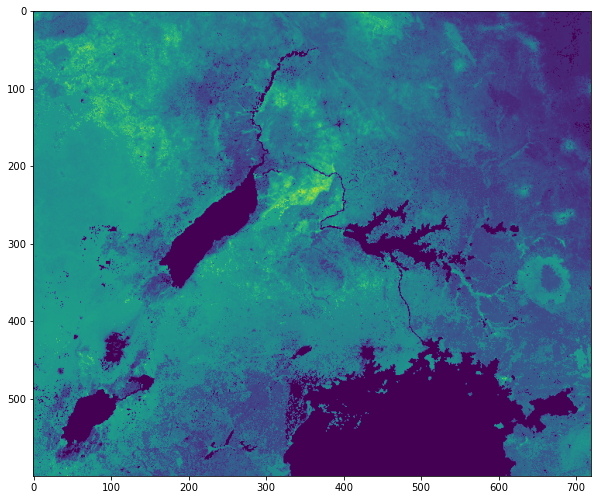

In [38]:
# plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.imshow(jim.np())
plt.show()

## Calculate median filter via scipy

In [39]:
from scipy import ndimage
npimage = ndimage.median_filter(jim.np(), size = 5)

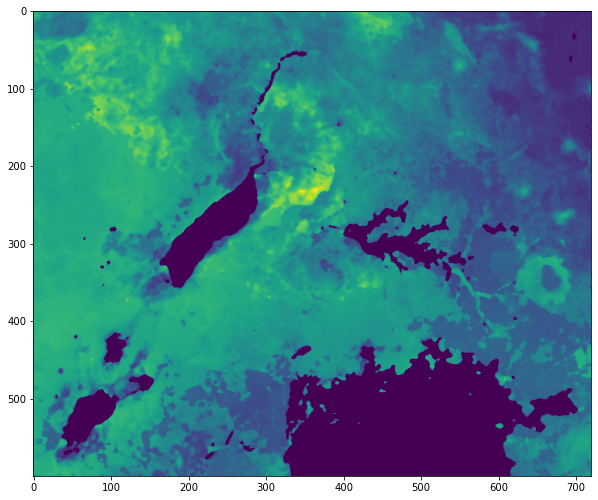

In [40]:
# plt.gray()  # show the filtered result in grayscale
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)
ax1.imshow(npimage)
plt.show()

## Exercise 4: Create a geospatial Jim object with CRS from a Numpy array

**A numpy array is not a geospatial dataset with a spatial coordinate reference system !**

In [41]:
ajim = pj.np2jim(npimage)
print(ajim.properties.getProjection())
print(ajim.properties.getGeoTransform())


[0.0, 1.0, 0.0, 0.0, 0.0, -1.0]


Use [setProjection](https://pyjeo.readthedocs.io/en/latest/3_reference.html#properties._Properties.setProjection) and [getProjection](https://pyjeo.readthedocs.io/en/latest/3_reference.html#properties._Properties.getProjection) to set the Coordinate Reference System (CRS) of ajim

## Calculating the median_filter in place using the output parameter

In [42]:
ndimage.median_filter(jim.np(), output = jim.np(), size = 5)

array([[0.       , 0.       , 0.       , ..., 0.7995924, 0.8013587,
        0.8027174],
       [0.       , 0.       , 3.6519022, ..., 0.7959239, 0.8013587,
        0.8027174],
       [0.       , 3.8828125, 3.8828125, ..., 0.7930027, 0.8013587,
        0.8027174],
       ...,
       [3.8717391, 3.8932745, 3.8932745, ..., 3.4084918, 3.327106 ,
        3.2286685],
       [3.860394 , 3.8717391, 3.860394 , ..., 3.517527 , 3.517527 ,
        3.327106 ],
       [3.448913 , 3.860394 , 3.448913 , ..., 3.517527 , 3.559375 ,
        3.359375 ]], dtype=float32)

As an alternative, we can set the Numpy representation of a Jim object in place

In [43]:
jim.np()[:] = ndimage.median_filter(jim.np(), size = 5)

## Bridging to third party libraries: Xarray

In [44]:
jim.xr()

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 1, y: 600, x: 720)
Coordinates:
  * time         (time) datetime64[ns] 8B 2019-08-11
  * y            (y) float64 5kB 3.996 3.988 3.979 ... -0.9792 -0.9875 -0.9958
  * x            (x) float64 6kB 29.0 29.01 29.02 29.03 ... 34.98 34.99 35.0
    spatial_ref  int64 8B 0
Data variables:
    ET           (time, y, x) float32 2MB 0.0 0.0 3.652 ... 3.491 3.454 3.408

**An Xarray dataset is defined with a spatial coordinate reference system !**

In [45]:
ajim = pj.xr2jim(jim.xr())

In [46]:
print(ajim.properties.getProjection())
print(ajim.properties.getGeoTransform())

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
[29.0, 0.008333333340001303, 0.0, 4.000000004, 0.0, -0.008333333339999971]


At the basis we find a Numpy data array

In [47]:
type(jim.xr().ET.data)

numpy.ndarray

### Calculate median filter via Xarray

Processing can take several minutes...

In [54]:
xr_median = jim.xr().ET.rolling(x = 3, y = 3, center=True).median()

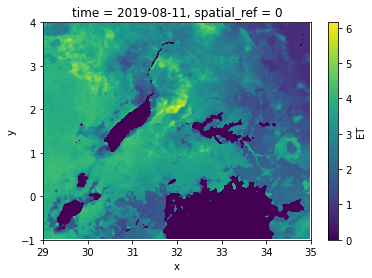

In [55]:
xr_median.plot()

**Notice that XArray member functions return the processed result and do not alter the input image !**

## Bridging JimVect to third party libraries

In [50]:
sample = pj.JimVect('geodata/shp/polygons.sqlite')

In [51]:
import pandas as pd
pdf = pd.DataFrame(sample.dict())
pdf

,ID
0,1
1,2
2,3


## Data extraction and regional statistics

In [52]:
extracted = pj.geometry.extract(sample, jim, rule='mean', output='/vsimem/mean.json', oformat='GeoJSON')

In [53]:
pdf = pd.DataFrame(extracted.dict())
pdf

,ID,b0
0,1,4.205908
1,2,1.595042
2,3,2.348307
